# Проект 3. О вкусной и здоровой пище (SF DST-60)
## (Георгий Виногродский)

Цель проекта - предсказать рейтинг ресторана в TripAdvisor на основе датасета, содержащего сведения о ресторанах Европы.

---

## Импорт библиотек

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import numpy as np
import missingno as msno
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta
import re
from textblob import TextBlob

params = {'figure.constrained_layout.use': False,
          'axes.facecolor': 'gainsboro',
          'axes.grid': True,
          'grid.linestyle': '--',
          'axes.labelsize': 12,
          'axes.titlesize': 14,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12}
plt.rcParams.update(params)
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

In [7]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [8]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [9]:
warnings.simplefilter("ignore")

---

<a id="0"></a>
# [СОДЕРЖАНИЕ](#0)
1. [1. Функции и предобработка](#1)
2. [2. Импорт данных и первичный осмотр](#2)
3. [3. Анализ и очистка переменных. Создание новых признаков](#3)
    * [3.1 Restaurant_id](#3.1)
    * [3.2 City](#3.2)
    * [3.3 Cuisine Style](#3.3)
    * [3.4 Ranking](#3.4)
    * [3.5 Price Range](#3.5)
    * [3.6 Reviews](#3.6)
        * [3.6.1 Обработка дат](#3.6.1)
        * [3.6.2 Обработка отзывов](#3.6.2)
    * [3.7 Number of Reviews](#3.7)
    * [3.8 URL_TA и ID_TA](#3.8)
4. [4. Data Preprocessing](#4)
5. [5. Model](#5)
6. [6. Submission](#6)

---

<a id="1"></a>
# [1. Функции и предобработка](#1)

Напишем здесь все функции, которые будут использоваться в дальнейшем:

In [10]:
def mm_scaler(df, column):
    '''Скалирование числовых перменных'''
    scl = MinMaxScaler()
    col = np.column_stack(df[column])
    col = np.reshape(col, (col.shape[1],1))
    return scl.fit_transform(col)

In [11]:
def get_jointplot(df, col_x, col_y):
    '''Вывод графика регрессии и корреляции'''
    df = df[df['sample'] == 1]
    corr = round(df[[col_x, col_y]].corr().values[0][1], 2)
    sns.jointplot(x=col_x, y=col_y, 
                  data=df, 
                  kind='reg', 
                  color='xkcd:darkish blue')
    print('----------------')
    print(f'Корреляция: {corr}')
    print('----------------')

In [12]:
def get_countplot(df, column):
    '''Первичный строковых перменных'''
    col = df[column].value_counts().sort_values(ascending=False)
    plt.figure(figsize=(12, 7), dpi=100)
    sns.countplot(df[column], order=col.index,
                  palette='Blues_r',
                  edgecolor='k',
                  linewidth=2)
    plt.xticks(rotation='vertical')
    plt.title(f'Распределение признака {column}', fontsize=15)
    plt.ylabel('Количество')
    for i, value in enumerate(col.values):  # Количество значений
        plt.text(i, value+1, value,
                 horizontalalignment='center',
                 fontsize=10,
                 rotation='vertical',
                 bbox={'facecolor': 'w'})
    return df[column].describe()

In [13]:
def get_histogram(df, column):
    '''Первичный осмотр числовых перменных'''
    col = df[column]
    counts, bins = np.histogram(col.dropna())
    plt.figure(figsize=(12, 7), dpi=100)
    plt.hist(bins[:-1],  bins,
            weights=counts,
            color='steelblue',
            edgecolor='k',
            linewidth=2)
    plt.title(f'Распределение признака {column}')
    plt.axvline(col.median(), color='w',
               linestyle='--', linewidth=3)
    plt.axvline(col.mean(), color='k',
               linestyle='--', linewidth=3)
    plt.text(col.mean()*1.01, max(counts)*0.9, # Среднее
            f'Mean: {round(col.mean(), 2)}', 
            color='w',fontsize=10, 
            bbox={'facecolor': 'k'})
    plt.text(col.median()*1.01, max(counts)*0.8, # Медиана
            f'Median: {round(col.median(), 2)}',
            fontsize=10, bbox={'facecolor': 'w', 
                               'edgecolor': 'w'})
    return df[column].describe()

In [14]:
def get_distplot(df, column):
    '''Вывод графика плотности распределения числовых перменных'''
    plt.figure(figsize=(12, 7), dpi=100)
    sns.distplot(df[column], bins=100, 
                 kde_kws={"color": "k", "lw": 3, "label": "KDE"}, 
                 hist_kws={"histtype": "bar", 
                           "color": 'steelblue', 
                           "edgecolor": 'k', 
                           "linewidth": 1, "alpha": 1})
    plt.ylabel('Плотность распределения')

In [15]:
def top_ten_cities(df, column):
    '''Распределение по городам'''
    plt.figure(figsize=(12, 7), dpi=100)
    colors = [plt.cm.Blues_r(i/float(10-1)) for i in range(10)]
    for i, city in enumerate(df['city'].value_counts()[0:10].index):
        df[column][df['city'] == city].hist(bins=20, label=city, 
                                       color=colors[i], 
                                       edgecolor='k', 
                                       linewidth=2)

    plt.legend(prop={'size': 10})
    plt.title(f'Распределение {column} по city', fontsize=15)
    plt.xlabel(column)
    plt.ylabel('Количество')

In [16]:
def first_look(df,column):
    '''Первичный осмотр перменных'''
    print(pct_missing(df,column))
    if df[column].dtype == 'O':
        return get_countplot(df,column)
    else:
        return get_histogram(df,column)

In [17]:
def get_stat_dif(df, col_x, col_y):
    '''Тест Стьюдента.
    
    Возвращает текст, если найдены
    статистически значимые различия.
    '''
    df = df[df['sample'] == 1]
    cols = df[col_x].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df[col_x] == comb[0], col_y],
                     df.loc[df[col_x] == comb[1], col_y]).pvalue \
                     <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            return 'ttest: значимые различия'
            break
    return 'ttest: различия не найдены'

In [18]:
def get_anova(df, col_x, col_y):
    '''Однофакторный дисперсионный анализ.
    
    Возвращает текст, если найдены статистически значимые различия.
    '''
    df = df[df['sample'] == 1]
    values = df[col_x].value_counts().index
    values_array = []
    for value in values:
        values_array.append(df.loc[df[col_x] == value, col_y])
    if f_oneway(*values_array).pvalue <= 0.05:
        return 'ANOVA: значимые различия'
    else:
        return 'ANOVA: различия не найдены'

In [19]:
def get_boxplot(df, col_x, col_y):
    '''Вывод боксплота.
    
    Также выводит информацию о прохождении тестов.
    '''
    df = df[df['sample'] == 1]
    y_max = df[col_y].max()*1.05
    y_min = df[col_y].max() - df[col_y].max()*1.05
    plt.figure(figsize=(12, 7), dpi=100)
    sns.boxplot(x=col_x, y=col_y,
                data=df, palette='Blues_r')
    plt.xticks(rotation='vertical')
    plt.ylim(y_min, y_max)
    plt.text(0, y_max, get_stat_dif(df, col_x, col_y), # ttest
            fontsize=10, bbox={'facecolor': 'w'})
    plt.text(0, y_min, get_anova(df, col_x, col_y), # ANOVA
            fontsize=10, bbox={'facecolor': 'w'})

In [20]:
def pct_missing(df, column):
    '''Процент пропусков в столбце'''
    return f'Процент пропусков в столбце {column}: {df[column].isna().mean()*100}'

In [21]:
def nan_column(df, column):
    '''Сохранение информации о пропусках'''
    df[column+'_nan'] = df[column].isna().astype('uint8')

In [22]:
def cuisine_rare(x, lst):
    '''Подсчет редких кухонь.
    
    Возвращает количество редких кухонь.
    '''
    number = 0
    for cuisine in lst:
        if cuisine in x:
            number += 1
    return number

In [23]:
def reviews_preproc(x):
    '''Формат строк в отзывах в списки.
    
    Также заменяет пропусками пустые списки.
    '''
    x = eval(x.replace('nan', '').replace('[,', "['',"))
    if len(x[0]) == 0 & len(x[1]) == 0:
        return np.nan
    else:
        return x

In [24]:
def reviews_separation(column):
    '''Разделение столбца с отзывами на отзывы и даты'''
    data['first_review'] = column.apply(
        lambda x: x[0][1] if len(x[0]) == 2 else np.nan)
    data['last_review'] = column.apply(
        lambda x: x[0][0] if len(x[0]) > 0 else np.nan)
    data['first_review_date'] = pd.to_datetime(column.apply(
        lambda x: x[1][1] if len(x[1]) == 2 else np.nan), format='%m/%d/%Y')
    data['last_review_date'] = pd.to_datetime(column.apply(
        lambda x: x[1][0] if len(x[1]) > 0 else np.nan), format='%m/%d/%Y')

In [25]:
def review_pol(review):
    '''Анализатор настроения текста
    
    Возвращает от -1 до 1 в зависимости от
    настроения тескта, -1 - максимально негативный,
    а 1 - максимально позитивный.
    '''
    return TextBlob(review).sentiment.polarity

In [26]:
def review_sub(review):
    '''Анализатор субъективности текста
    
    Возвращает от 0 до 1 в зависимости от
    настроения тескта, 0 - максимально объективный,
    а 1 - максимально субъективный.
    '''
    return TextBlob(review).sentiment.subjectivity

In [27]:
def magnify():
    '''Настройки стиля для карты корреляций'''
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])]

In [28]:
def round_prediction(rating_pred):
    '''Округление предсказанного рейтинга'''
    if rating_pred <= 0.5:
        return 0.0
    if rating_pred <= 1.5:
        return 1.0
    if rating_pred <= 1.75:
        return 1.5
    if rating_pred <= 2.25:
        return 2.0
    if rating_pred <= 2.75:
        return 2.5
    if rating_pred <= 3.25:
        return 3.0
    if rating_pred <= 3.75:
        return 3.5
    if rating_pred <= 4.25:
        return 4.0
    if rating_pred <= 4.75:
        return 4.5
    return 5.0

[К содержанию](#0)

---

<a id="2"></a>
# [2. Импорт данных и первичный осмотр](#2)

In [29]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')
pd.set_option('display.max_columns', 200)

In [30]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [31]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [32]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [33]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [34]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [35]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [36]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* *__Restaurant_id__* — идентификационный номер ресторана / сети ресторанов;
* *__City__* — город, в котором находится ресторан;
* *__Cuisine Style__* — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
* *__Ranking__* — место, которое занимает данный ресторан среди всех ресторанов своего города;
* *__Rating__* — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
* *__Price Range__* — диапазон цен в ресторане;
* *__Number of Reviews__* — количество отзывов о ресторане;
* *__Reviews__* — данные о двух отзывах, которые отображаются на сайте ресторана;
* *__URL_TA__* — URL страницы ресторана на TripAdvisor;
* *__ID_TA__* — идентификатор ресторана в базе данных TripAdvisor.

In [38]:
data.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


Посмотрим тип данных в переменных:

In [39]:
for column in data.columns:
    print(f'Тип данных в переменной {column}: {type(data[column].dropna()[0])}')

Тип данных в переменной Restaurant_id: <class 'str'>
Тип данных в переменной City: <class 'str'>
Тип данных в переменной Cuisine Style: <class 'str'>
Тип данных в переменной Ranking: <class 'numpy.float64'>
Тип данных в переменной Price Range: <class 'str'>
Тип данных в переменной Number of Reviews: <class 'numpy.float64'>
Тип данных в переменной Reviews: <class 'str'>
Тип данных в переменной URL_TA: <class 'str'>
Тип данных в переменной ID_TA: <class 'str'>
Тип данных в переменной sample: <class 'numpy.int64'>
Тип данных в переменной Rating: <class 'numpy.float64'>


Посмотрим внимательнее на строковые перменные:

In [40]:
for col in data.columns:
    if data[col].dtype == 'O':
        print(f'Столбец: {col}, значения: {data[col].unique()[:3]}\n')

Столбец: Restaurant_id, значения: ['id_0' 'id_1' 'id_2']

Столбец: City, значения: ['Paris' 'Helsinki' 'Edinburgh']

Столбец: Cuisine Style, значения: ["['Bar', 'Pub']"
 "['European', 'Scandinavian', 'Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options']"
 "['Vegetarian Friendly']"]

Столбец: Price Range, значения: ['$$ - $$$' '$$$$' '$']

Столбец: Reviews, значения: ['[[], []]'
 "[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"
 "[['Better than the Links', 'Ivy Black'], ['12/28/2017', '12/06/2017']]"]

Столбец: URL_TA, значения: ['/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html'
 '/Restaurant_Review-g189934-d6674944-Reviews-Ravintola_Kolmon3n-Helsinki_Uusimaa.html'
 '/Restaurant_Review-g186525-d13129638-Reviews-Black_Ivy-Edinburgh_Scotland.html']

Столбец: ID_TA, значения: ['d10746918' 'd6674944' 'd13129638']



Посмотрим, что с пропущенныим значениями:

In [41]:
for column in data.columns:
    print(pct_missing(data, column))

Процент пропусков в столбце Restaurant_id: 0.0
Процент пропусков в столбце City: 0.0
Процент пропусков в столбце Cuisine Style: 23.18
Процент пропусков в столбце Ranking: 0.0
Процент пропусков в столбце Price Range: 34.721999999999994
Процент пропусков в столбце Number of Reviews: 6.4
Процент пропусков в столбце Reviews: 0.004
Процент пропусков в столбце URL_TA: 0.0
Процент пропусков в столбце ID_TA: 0.0
Процент пропусков в столбце sample: 0.0
Процент пропусков в столбце Rating: 0.0


<AxesSubplot:>

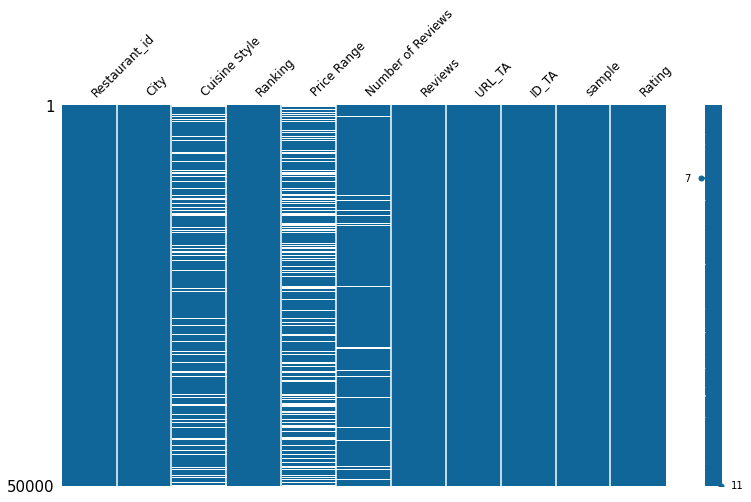

In [42]:
msno.matrix(data, figsize=(12, 7), fontsize=12, color=(0.07, 0.4, 0.6))

В датасете 50000 строк, 11 стобцов, из них 4 - числовые, 7 - строковые. В столбцах __Cuisine Style__, __Price Range__, __Number of Reviews__ и __Reviews__ присутствуют пустые значения. В дальнейшем решим, как заполнить пропуски. Данные достаточно грязные и требуют обработки. В столбцах __Cuisine Style__ и __Reviews__ за строками прячутся списки.

Для начала приведем названия столбцов к одному виду:

In [43]:
data.columns = [col.lower() for col in data.columns]
data.columns = [col.replace(' ', '_') for col in data.columns]

[К содержанию](#0)

---

<a id="3"></a>
# [3. Анализ и очистка переменных. Создание новых признаков](#3)

Посмотрим на каждый признак по отдельности и проведем предварительную обработку.

<a id="3.1"></a>
# [3.1 Restaurant_id](#3.1)

In [44]:
print(pct_missing(data, 'restaurant_id'))

Процент пропусков в столбце restaurant_id: 0.0


In [45]:
data['restaurant_id'].describe()

count      50000
unique     13094
top       id_871
freq          19
Name: restaurant_id, dtype: object

У переменной всего 13к уникальных значений при 50к строк. По информации к датасету можно предположить, что дубликаты - это сетевые рестораны. Создадим отдельный признак на основе этой информации:

In [46]:
chain_lst = list(data['restaurant_id'].value_counts()[data['restaurant_id'].value_counts() > 1].index)

In [47]:
data['chained'] = data[data['restaurant_id'].isin(chain_lst)]['restaurant_id'].apply(lambda x: 1)
data['chained'].fillna(0, inplace=True)

Переведем значения в числа для дальнейшего применения в модели:

In [48]:
data['restaurant_id'] = data['restaurant_id'].apply(lambda x: int(x[3:]))

[К содержанию](#0)

---

<a id="3.2"></a>
# [3.2 City](#3.2)

Процент пропусков в столбце city: 0.0


count      50000
unique        31
top       London
freq        7193
Name: city, dtype: object

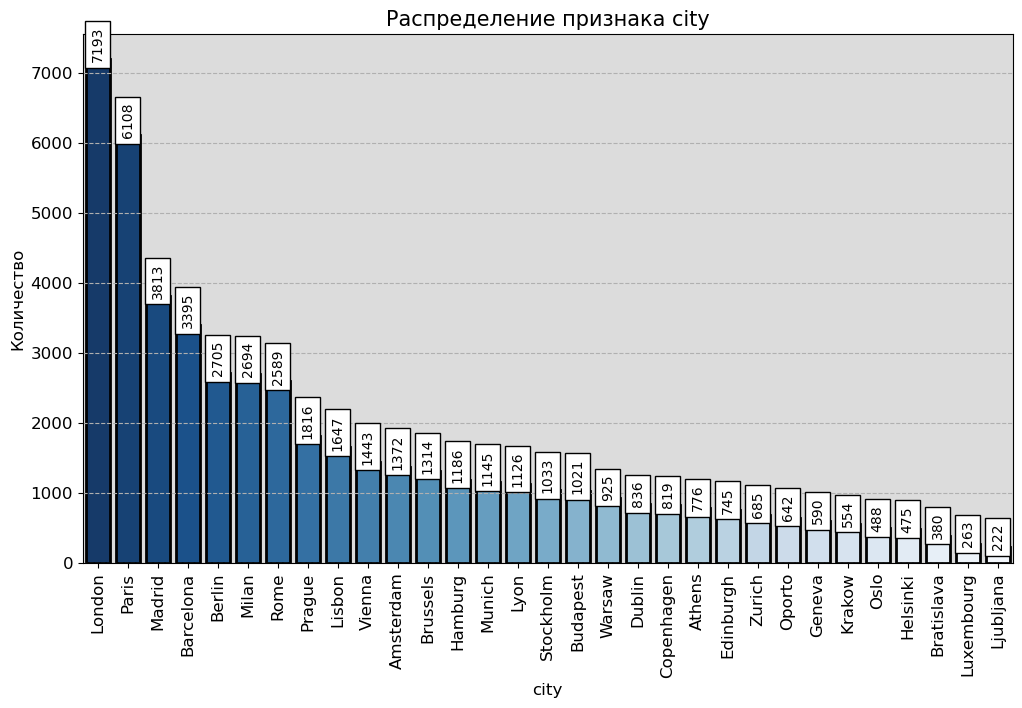

In [49]:
first_look(data, 'city')

Судя по графику в датасете представлены только европейские города. Лондон и Париж значительно опережают остальные города по количеству ресторанов. Возможно это связано размером населения в городе.

Переименуем __Oporto__ в __Porto__:

In [50]:
data['city'] = data['city'].replace(['Oporto'], 'Porto')

Для проверки предположения о взаимосвязи размера населения и количества ресторанов возьмем данные из датасета о городах:

In [51]:
df_cities = pd.read_csv('worldcities.csv')

In [52]:
df_cities.sample(3)

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
1343,Halifax,Halifax,44.6500,-63.6000,Canada,CA,CAN,Nova Scotia,admin,359111.0,1124130981
7828,Qing’an,Qing'an,46.8719,127.5118,China,CN,CHN,Heilongjiang,minor,53206.0,1156233891
2723,Pābna,Pabna,24.0004,89.2500,Bangladesh,BD,BGD,NaN,NaN,137888.0,1050424286


Отфильтруем датасет по названиям городов из основного датасета, а также уточним, что города находятся в Европе:

In [53]:
df_cities = df_cities[(df_cities['city_ascii'].isin(data['city'].unique()))&
                      (df_cities['lng'] > -11)&
                      (df_cities['lng'] < 40)]

Оставим данные о населении города. Также оставим данные о стране, где город расположен. Эти данные понадобятся в дальнейшем для создания новых признаков. Еще оставим данные о том, является ли город столицей. Остальные столбцы удалим:

In [54]:
df_cities = df_cities.drop(['city', 'lat', 'lng','iso2', 'iso3', 'admin_name',  'id'], axis=1)

Присоединим то, что осталось к основному датасету:

In [55]:
data = data.join(df_cities.set_index('city_ascii'), on='city')

Переведем информацию от столице в числовой вид для дальнейшего использования в модели:

In [56]:
'''1 если столица, иначе - 0'''
data['capital'] = data['capital'].apply(lambda x: 1 if x == 'primary' else 0)

Проверим предположение о взаимосвязи размера населения и количества ресторанов. Создадим новый признак - количество ресторанов в городе:

In [57]:
city_counts_dict = dict(data['city'].value_counts())

In [58]:
data['rest_counts'] = data['city'].map(city_counts_dict)

----------------
Корреляция: 0.96
----------------


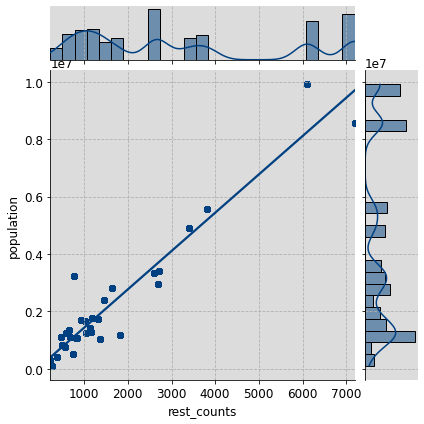

In [59]:
get_jointplot(data, 'rest_counts', 'population')

Почти полная положительная корреляция подверждает - чем больше в городе людей, тем больше ресторанов.

Создадим новый признак на основе этой информации - количество ресторанов на тысячу человек:

In [60]:
data['rest_counts_to_population'] = data['rest_counts']/data['population']*1000

Посмотрим распределение по городам относительно целевой переменной:

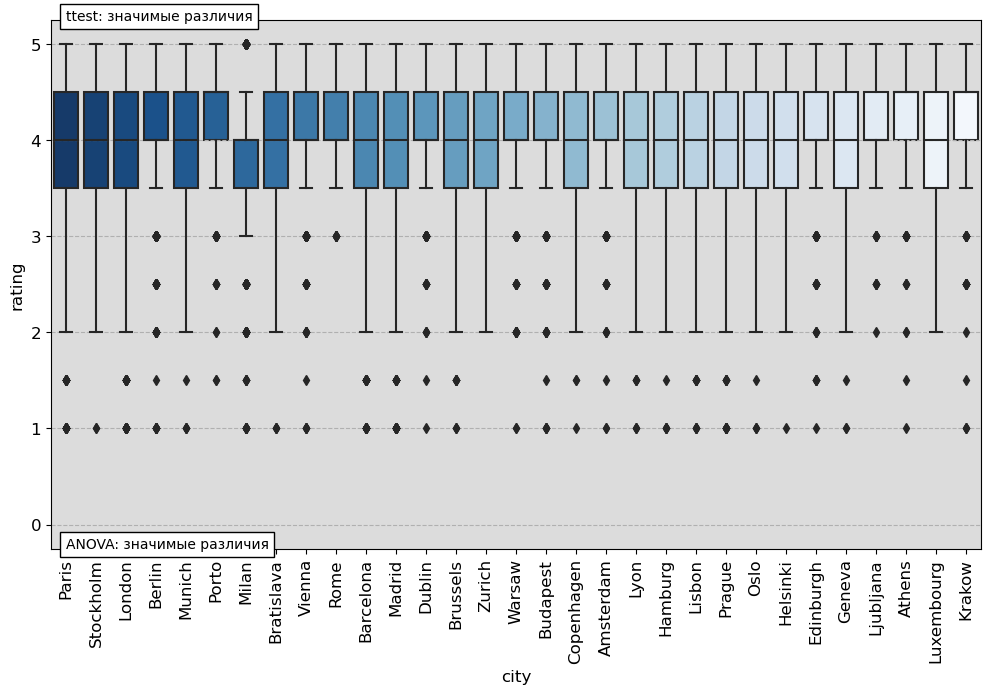

In [61]:
get_boxplot(data[data['sample'] == 1], 'city', 'rating')

Судя по графику рестораны в Риме плохо не оцениваются. А в Милане найти ресторан с высшей оценкой будет очень сложно.
Оба статистических теста показвают взаимосвязь между городом, где расположен ресторан, и рейтингом.

Добавим информацию об уровне жизни в стране, где расположен город. Подгрузим соответсвующий датасет:

In [62]:
df_living_cost = pd.read_csv('cost of living 2020.csv')

In [63]:
df_living_cost.sample(3)

,Rank 2020,Country,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,McMeal($),Unnamed: 9
101,102,Rwanda,36.21,14.64,25.71,29.74,30.74,20.54,0.00,NaN
22,23,New Zealand,71.83,31.74,52.31,66.29,63.05,87.22,8.36,NaN
38,39,Greece,57.50,11.89,35.29,43.67,52.42,40.75,7.55,NaN


Приведем названия столбцов к одному виду:

In [64]:
df_living_cost.columns = [col.lower() for col in df_living_cost.columns]
df_living_cost.columns = [col.replace(' ', '_') for col in df_living_cost.columns]

Проверим соответсвие списка стран из нашего датасета с подгруженным датасетом:

In [65]:
for country in data['country'].unique():
    if country not in df_living_cost['country'].unique():
        print(country)

Czechia


Вряд ли Чехия отсутсвует в датасете. Вероятно в данном датасете она имеет другое написание. Проверим это:

In [66]:
for country in df_living_cost['country'].unique():
    if 'Cz' in country:
        print(country)

Czech Republic


Так и есть. Поменяем название, чтобы в дальнейшем присоединить нужные нам признаки к основному датасету:

In [67]:
df_living_cost['country'] = df_living_cost['country'].replace(['Czech Republic'], 'Czechia')

Отфильтруем датасет по странам из основного датасета:

In [68]:
df_living_cost = df_living_cost[df_living_cost['country'].isin(data['country'].unique())]

Удалим ненужный столбец:

In [69]:
df_living_cost = df_living_cost.drop(['unnamed:_9'], axis=1)

Посмотрим на карту корреляции в датасете по уровню жизни:

In [70]:
corr = df_living_cost.dropna(axis=1).corr()
corr.style.background_gradient(axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,rank_2020,cost_of_living_index,rent_index,cost_of_living_plus_rent_index,groceries_index,restaurant_price_index,local_purchasing_power_index,mcmeal($)
rank_2020,1.00,-0.90,-0.76,-0.89,-0.82,-0.94,-0.79,-0.52
cost_of_living_index,-0.90,1.00,0.82,0.98,0.98,0.97,0.81,0.62
rent_index,-0.76,0.82,1.00,0.92,0.78,0.81,0.80,0.19
cost_of_living_plus_rent_index,-0.89,0.98,0.92,1.00,0.95,0.96,0.84,0.49
groceries_index,-0.82,0.98,0.78,0.95,1.00,0.91,0.75,0.60
restaurant_price_index,-0.94,0.97,0.81,0.96,0.91,1.00,0.85,0.60
local_purchasing_power_index,-0.79,0.81,0.80,0.84,0.75,0.85,1.00,0.44
mcmeal($),-0.52,0.62,0.19,0.49,0.60,0.60,0.44,1.00


Наблюдается сильная корреляция большинства признаков между собой. Уберем часть скоррелированных признаков из выборки, так как они несут избыточную информацию:

In [71]:
df_living_cost = df_living_cost.drop(['cost_of_living_plus_rent_index', 'restaurant_price_index'], axis=1)

Остальные признаки добавим к нашему датасету:

In [72]:
data = data.join(df_living_cost.set_index('country'), on='country')

Закодируем страны в отдельный признак:

In [73]:
le = LabelEncoder()
le.fit(data['country'])
data['code_country'] = le.transform(data['country'])

Преобразуем признак city в dummy-переменные

In [74]:
data_city_dummies = pd.get_dummies(data['city'], dummy_na=False).astype('float64')
data = pd.concat([data,data_city_dummies], axis=1)

[К содержанию](#0)

---

<a id="3.3"></a>
# [3.3. Cuisine Style](#3.3)

In [75]:
print(pct_missing(data, 'cuisine_style'))

Процент пропусков в столбце cuisine_style: 23.18


In [76]:
data['cuisine_style'].describe()

count           38410
unique          10731
top       ['Italian']
freq             1332
Name: cuisine_style, dtype: object

В столбце достаточно много пропусков. Сохраним информацию о пропусках в отдельную переменную:

In [77]:
nan_column(data, 'cuisine_style')

А пропуски заполним значением __Other__:

In [78]:
data['cuisine_style'].fillna("['Other']", inplace=True)

Перед дальнейшей обработкой закодируем значения в отдельный признак:

In [79]:
le = LabelEncoder()
le.fit(data['cuisine_style'])
data['code_cuisine_style'] = le.transform(data['cuisine_style'])

Сделаем из строковых списков - натуральные:

In [80]:
data['cuisine_style'] = data['cuisine_style'].apply(lambda x: eval(x))

Посмотрим, сколько уникальных кухонь представлено в датасете, и каких кухонь больше:

In [81]:
explode_cs = data.explode('cuisine_style')

Количество уникальных кухонь, представленных в датасете: 125


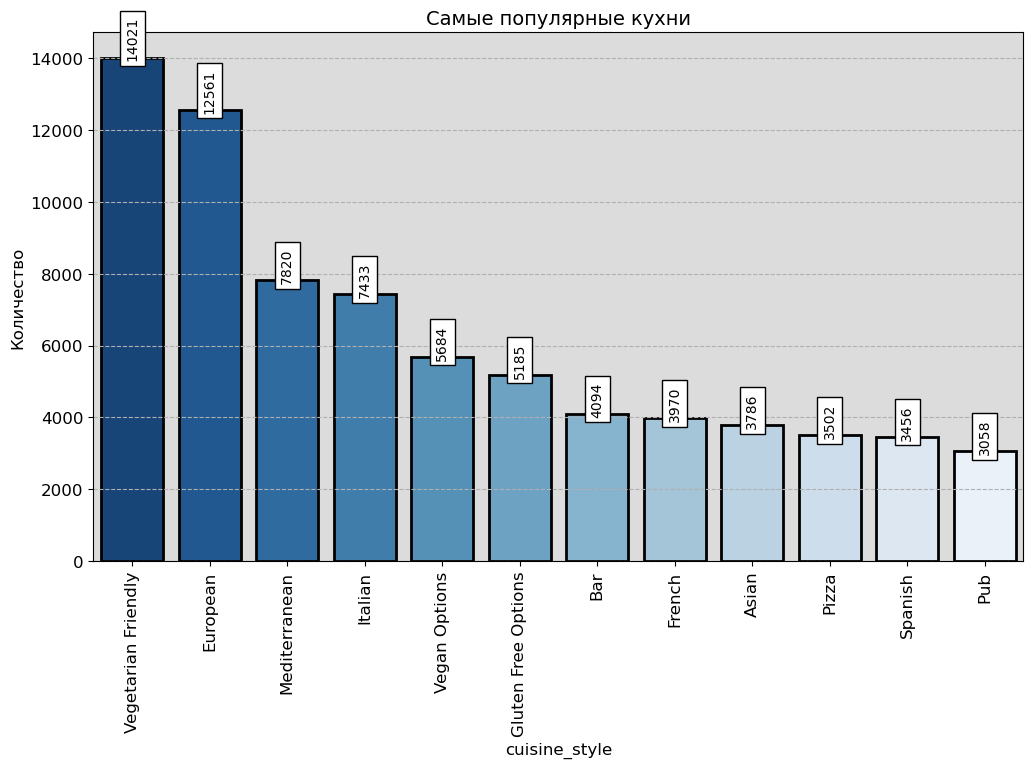

In [82]:
max_cuisine = explode_cs['cuisine_style'].nunique()-1
col = explode_cs[explode_cs['cuisine_style'] != 'Other']['cuisine_style'].\
                value_counts().sort_values(ascending=False)[:round(max_cuisine*0.1)]
plt.figure(figsize=(12, 7), dpi=100)
sns.countplot(explode_cs['cuisine_style'], order=col.index,
              palette='Blues_r',
              edgecolor='k',
              linewidth=2)
plt.title('Самые популярные кухни')
plt.xticks(rotation='vertical')
plt.ylabel('Количество')
for i, value in enumerate(col.values):
    plt.text(i, value+1, value,
             horizontalalignment='center',
             fontsize=10,
             rotation='vertical',
             bbox={'facecolor': 'w'})
print(f'Количество уникальных кухонь, представленных в датасете: {max_cuisine}')

В датасете представлено 125 уникальных кухонь. Самые популярные кухни - это европейская, что понятно, и пригодная для вегетаринцев.

Создадим новый признак, показвающий количество кухонь представленных в ресторане:

In [83]:
data['cuisine_counts'] = data['cuisine_style'].apply(lambda x: len(x))

Посмотрим на новый признак:

Процент пропусков в столбце cuisine_counts: 0.0


count    50000.000000
mean         2.625320
std          1.824029
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         21.000000
Name: cuisine_counts, dtype: float64

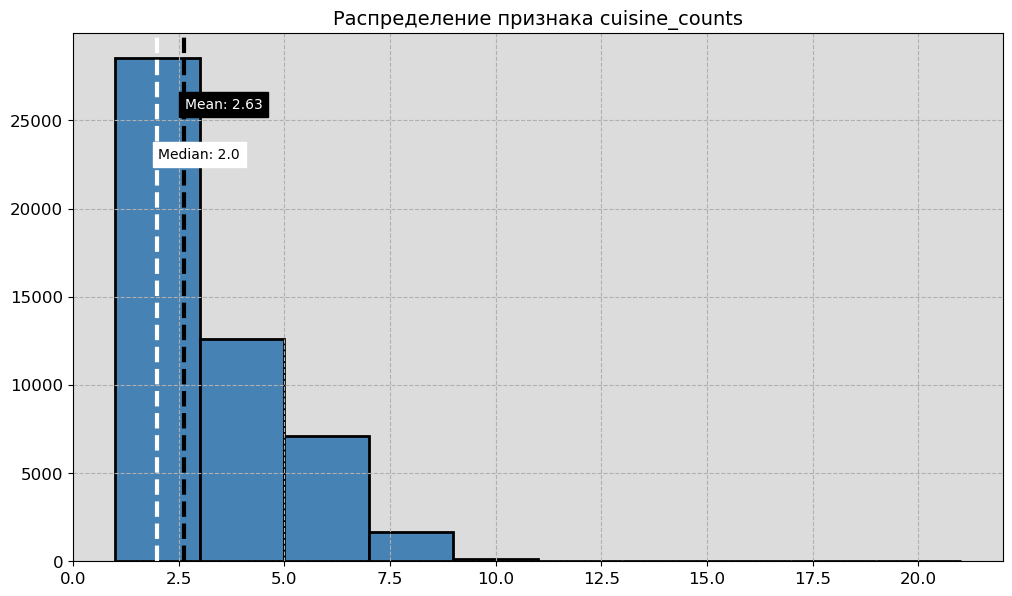

In [84]:
first_look(data, 'cuisine_counts')

В среднем в ресторане представлено 2-3 кухни. Но есть ресторан, где представлена 21 кухня! Посмотрим на него:

In [85]:
print(data[data['cuisine_counts'] == 21]['url_ta'].values)

['/Restaurant_Review-g188590-d7231902-Reviews-Foodhallen-Amsterdam_North_Holland_Province.html']


Посмотрим, какие кухни самые редкие:

In [86]:
explode_cs[explode_cs['cuisine_style'] != 'Other']['cuisine_style'].\
        value_counts().sort_values(ascending=True)[:round(max_cuisine*0.2)]

Salvadoran           1
Latvian              1
Xinjiang             1
Burmese              1
Polynesian           2
Fujian               2
Yunnan               2
Azerbaijani          3
Welsh                3
Caucasian            4
Native American      5
Uzbek                5
New Zealand          7
Canadian             7
Albanian             8
Ecuadorean           8
Central Asian       12
Minority Chinese    12
Romanian            13
Chilean             16
Filipino            17
Armenian            17
Georgian            18
Mongolian           20
Ukrainian           20
Name: cuisine_style, dtype: int64

Создадим на основе этой информации новый признак:

In [87]:
rare_cuisine_lst = explode_cs[explode_cs['cuisine_style'] != 'Other']['cuisine_style'].\
                    value_counts().sort_values(ascending=True)[:round(max_cuisine*0.2)].index.tolist()

In [88]:
data['rare_cuisine'] = data['cuisine_style'].apply(lambda x: cuisine_rare(x, rare_cuisine_lst))

In [89]:
data['rare_cuisine'].value_counts()

0    49807
1      182
2       10
3        1
Name: rare_cuisine, dtype: int64

[К содержанию](#0)

---

<a id="3.4"></a>
# [3.4 Ranking](#3.4)

Процент пропусков в столбце ranking: 0.0


count    50000.000000
mean      3664.427520
std       3700.092452
min          1.000000
25%        972.000000
50%       2278.000000
75%       5241.000000
max      16444.000000
Name: ranking, dtype: float64

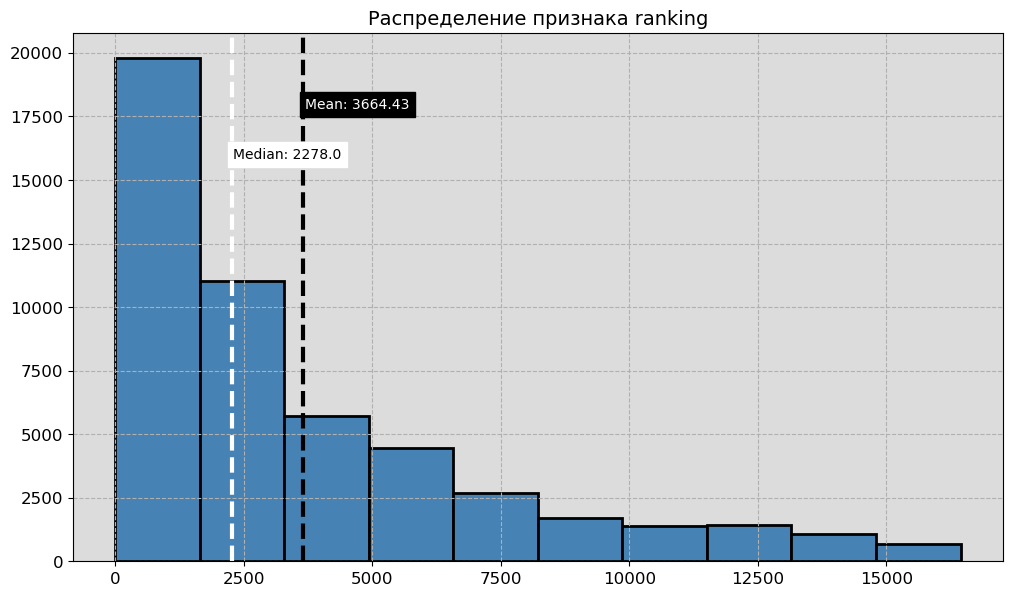

In [90]:
first_look(data, 'ranking')

Распределение сильно смещено влево с высоким максимальным значением. Но судя по данным к датасету, переменная __Ranking__ показвает место, которое ресторан занимает среди всех ресторанов в своем городе. Поэтому мы не можем наблюдать его отдельно от городов:

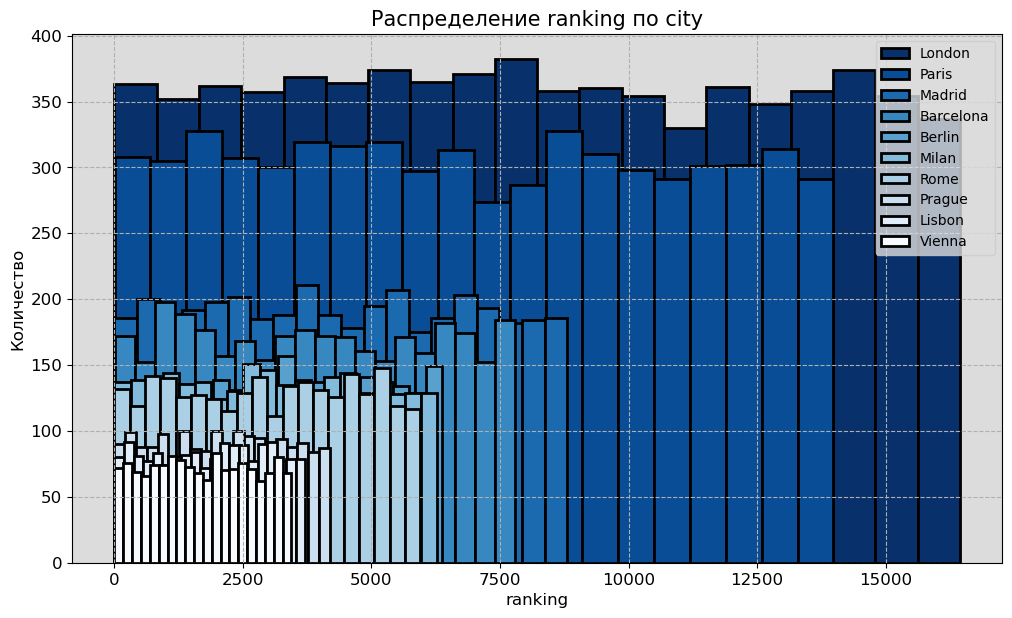

In [91]:
top_ten_cities(data, 'ranking')

Получается, что __Ranking__ имеет нормальное распределение. Чем больше город, тем больше ресторанов.

Создадим на основе этой информации новый признак - отношение количества ресторанов к рангу:

In [92]:
data['rank_to_rest_counts'] = data['ranking']/data['rest_counts']

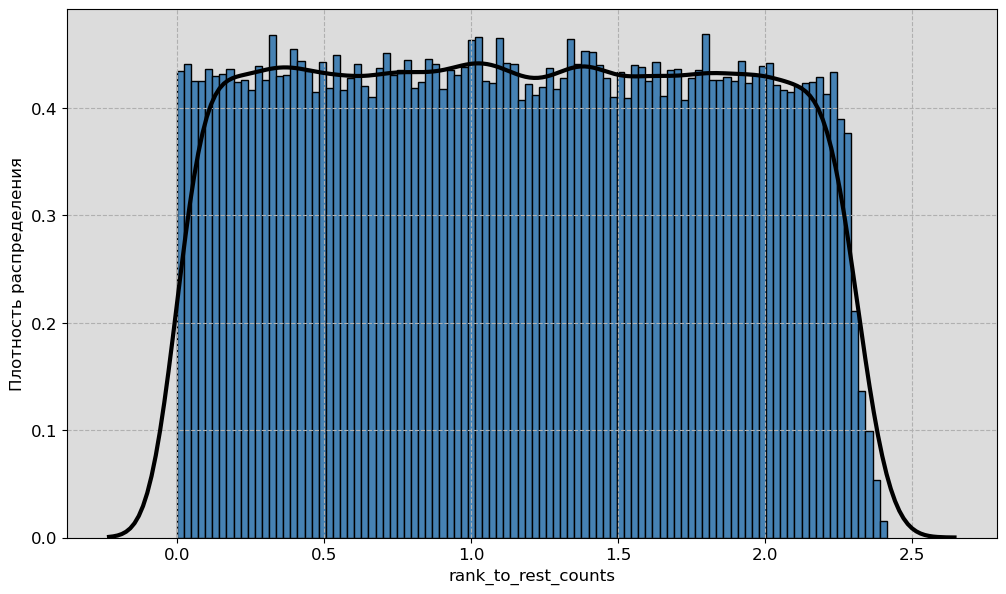

In [93]:
get_distplot(data, 'rank_to_rest_counts')

Теперь рапределение нормально и не зависит от города. Проверим по городам:

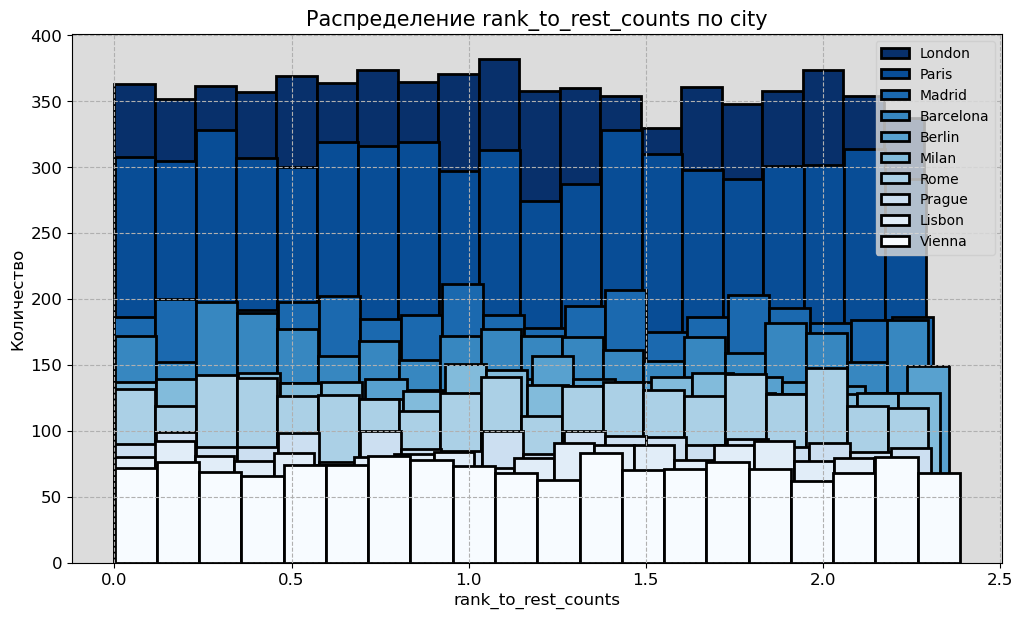

In [94]:
top_ten_cities(data, 'rank_to_rest_counts')

Распределение действительно выровнялось.

Мы уже выяснили, что количество ресторанов связано с размером населения в городе. Значит и с рангом должна быть взаимосвязь:

----------------
Корреляция: 0.68
----------------


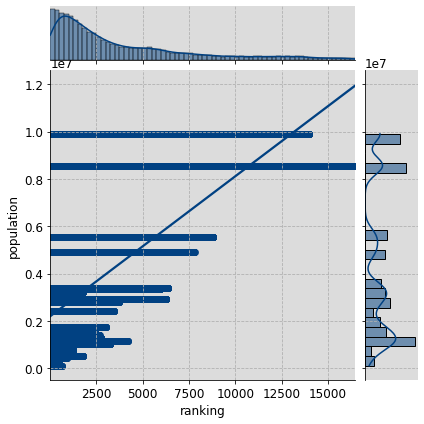

In [95]:
get_jointplot(data, 'ranking', 'population')

Между признаками действительно есть положительная взаимосвязь. Выделим эту взаимосвязь в отдельный признак:

In [96]:
data['rank_to_population'] = data['ranking']/data['population']*1000

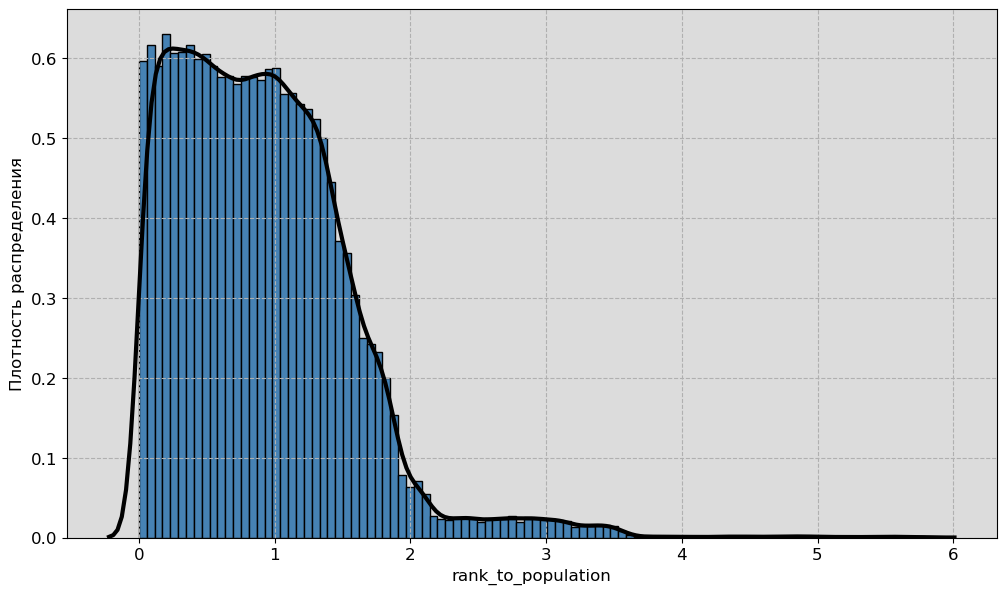

In [97]:
get_distplot(data, 'rank_to_population')

Распределение сохранило смещение влево. Посмотрим, что там по городам:

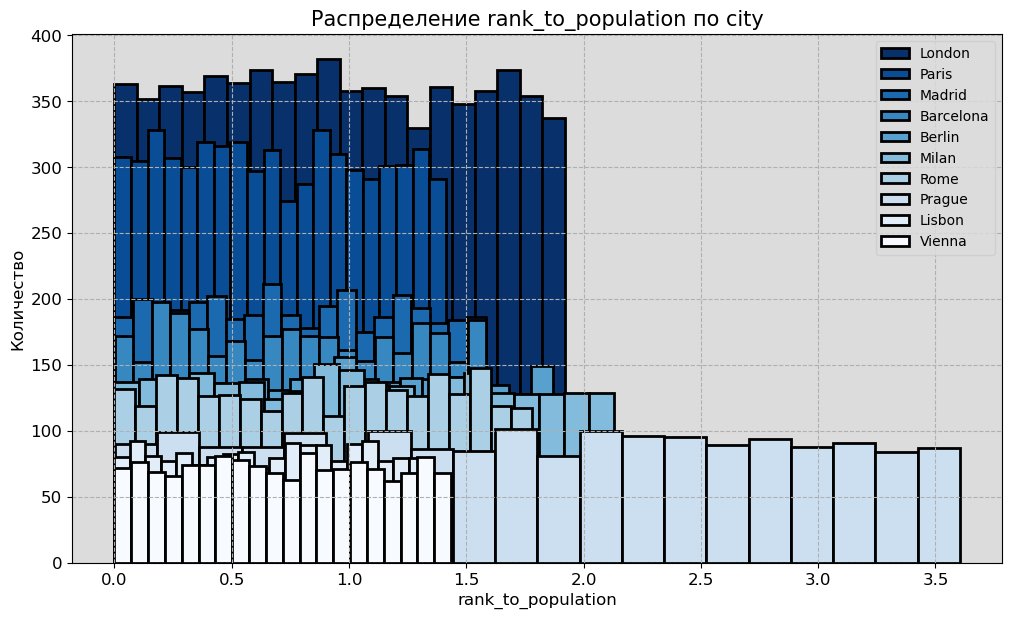

In [98]:
top_ten_cities(data, 'rank_to_population')

Получается, что в Праге в среднем ранг ресторана значительно выше по отношению к плотности населения, чем в остальных городах.

[К содержанию](#0)

---

<a id="3.5"></a>
# [3.5 Price Range](#3.5)

In [99]:
print(pct_missing(data, 'price_range'))

Процент пропусков в столбце price_range: 34.721999999999994


In [100]:
data['price_range'].describe()

count        32639
unique           3
top       $$ - $$$
freq         23041
Name: price_range, dtype: object

В столбце достаточно много пропусков. Сохраним информацию о пропусках в отдельную переменную:

In [101]:
nan_column(data, 'price_range')

Заменим значения на числовые в зависимости от дороговизны ресторана:

In [102]:
price_ranges = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
data['price_range'] = data['price_range'].dropna().map(price_ranges)

Посмотрим на распределение по ценам относительно целевой переменной:

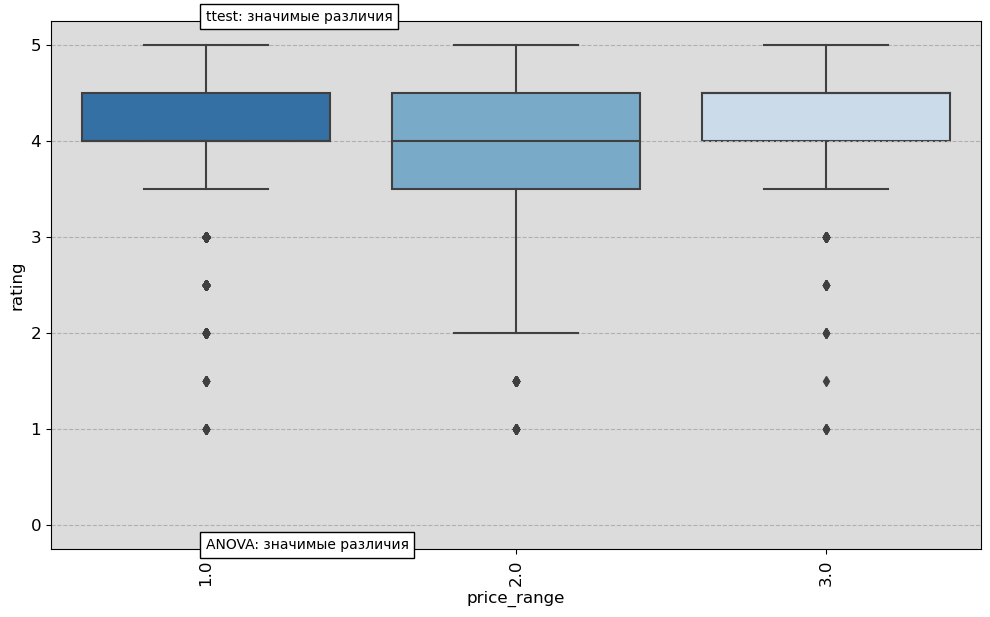

In [103]:
get_boxplot(data[data['sample'] == 1], 'price_range', 'rating')

Заметно, что в среднем райтинг ниже у ресторанов средней ценовой категории. Это можно объяснить тем, что их просто значительно больше, чем дешевых и дорогих ресторанов.

Посмотрим самое частое значение по городам:

In [104]:
for city in data['city'].unique():
    print(city,  data[data['city'] == city]['price_range'].mode()[0])

Paris 2.0
Helsinki 2.0
Edinburgh 2.0
London 2.0
Bratislava 2.0
Lisbon 2.0
Budapest 2.0
Stockholm 2.0
Rome 2.0
Milan 2.0
Munich 2.0
Hamburg 2.0
Prague 2.0
Vienna 2.0
Dublin 2.0
Barcelona 2.0
Brussels 2.0
Madrid 2.0
Oslo 2.0
Amsterdam 2.0
Berlin 2.0
Lyon 2.0
Athens 2.0
Warsaw 2.0
Porto 2.0
Krakow 2.0
Copenhagen 2.0
Luxembourg 2.0
Zurich 2.0
Geneva 2.0
Ljubljana 2.0


Самое частое значение по всем городам - это средняя ценовая категория. Заполним модой пустые значения в переменной:

In [105]:
data['price_range'].fillna(data['price_range'].mode()[0], inplace=True)

[К содержанию](#0)

---

<a id="3.6"></a>
# [3.6 Reviews](#3.6)

In [106]:
print(pct_missing(data, 'reviews'))

Процент пропусков в столбце reviews: 0.004


In [107]:
data['reviews'].describe()

count        49998
unique       41857
top       [[], []]
freq          8112
Name: reviews, dtype: object

Всего 2 пропуска. Но самое частое значение - это список с пустыми списками, которое можно воспринимать, как пропуск. Также нам известно, что значения в данной переменной имеют строковый тип данных, хотя с виду это список. Обработаем данные, чтобы вернуть списки в значениях, а также заменим пустые списки пропусками:

In [108]:
data['reviews'] = data['reviews'].dropna().apply(reviews_preproc)

При первичном осмотре можно было заметить, что о части ресторанах был оставлен только один отзыв. Создадим новый признак на основе этой информации:

In [109]:
data['len_last_reviews'] = data['reviews'].apply(lambda x: len(x[0]) if x == x else 0)

Создадим на основе __'Reviews'__ четыре новых признака - первый отзыв, последний отзыв, дата первого отзыва и дата последнего отзыва:

In [110]:
reviews_separation(data['reviews'].dropna())

Обработаем по отдельности столбцы с датами и столбцы с отзывами:

[К содержанию](#0)

<a id="3.6.1"></a>
# [3.6.1 Обработка дат](#3.6.1)

In [111]:
data['last_review_date'].describe()

count                   41886
unique                   1976
top       2018-01-07 00:00:00
freq                      607
first     2004-04-21 00:00:00
last      2018-02-26 00:00:00
Name: last_review_date, dtype: object

Создадим новый признак - разница в днях между отзывами:

In [112]:
data['days_from_first_to_last'] = data[data['len_last_reviews'] == 2]\
[['last_review_date', 'first_review_date']].apply(lambda date: abs(date[0]-date[1]).days, axis=1)

Процент пропусков в столбце days_from_first_to_last: 27.589999999999996


count    36205.000000
mean       142.549399
std        222.557409
min          0.000000
25%         20.000000
50%         67.000000
75%        173.000000
max       3296.000000
Name: days_from_first_to_last, dtype: float64

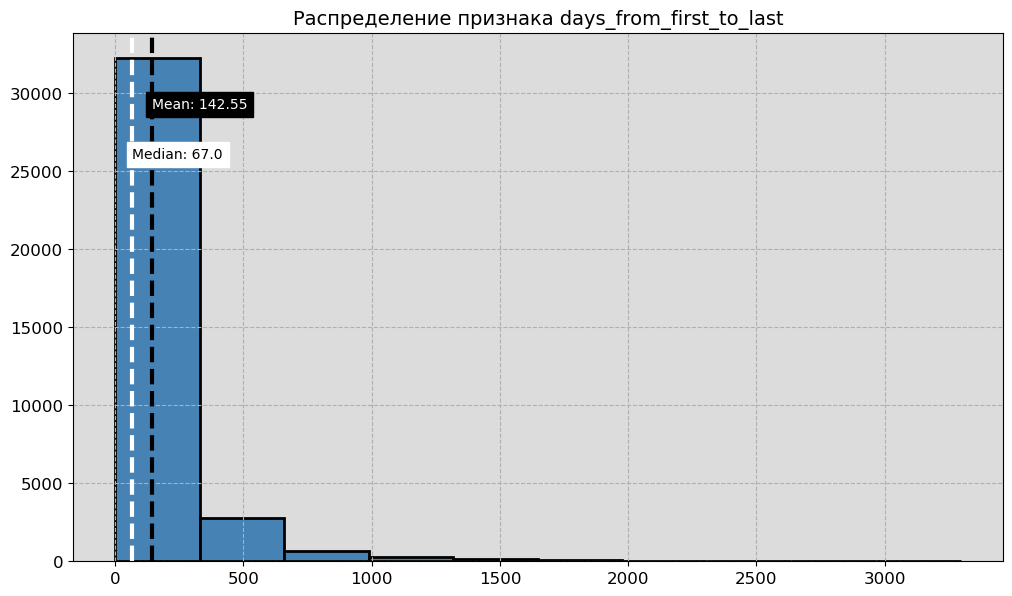

In [113]:
first_look(data, 'days_from_first_to_last')

Теперь посчитаем сколько прошло времени от написания последнего отзыва до сегодняшнего дня:

In [114]:
data['days_from_last_to_now'] = (datetime.now() - data['last_review_date'].dropna()).dt.days

Заполним пропуски нулями:

In [115]:
data['days_from_first_to_last'] = data['days_from_first_to_last'].fillna(0)
data['days_from_last_to_now'] = data['days_from_last_to_now'].fillna(0)

[К содержанию](#0)

<a id="3.6.2"></a>
# [3.6.2 Обработка отзывов](#3.6.2)

Для начала сохраним информациию о пропусках в столбцах с отзывами:

In [116]:
nan_column(data, 'first_review')
nan_column(data, 'last_review')

Заполним пропуски показателем отсутствия отзывов __'no review'__:

In [117]:
data['first_review'] = data['first_review'].fillna('no review')
data['last_review'] = data['last_review'].fillna('no review')

Почистим текст в отзывах от лишних символов для улучшения дальнейшего тонального анализа:

In [118]:
reg = re.compile('[^a-zA-Z ]')
data['first_review'] = data['first_review'].apply(lambda text: reg.sub('',text))
data['last_review'] = data['last_review'].apply(lambda text: reg.sub('',text))

Теперь проведем тональный анализ с помощью библиотеки TextВlob. Создадим новые признаки - настроение отзыва и его субъективность:

In [119]:
#Анализ проходит довольно медленно
data['first_review_pol'] = data['first_review'].apply(review_pol)
data['first_review_sub'] = data['first_review'].apply(review_sub)
data['last_review_pol'] = data['last_review'].apply(review_pol)
data['last_review_sub'] = data['last_review'].apply(review_sub)

Посмотрим, что получилось:

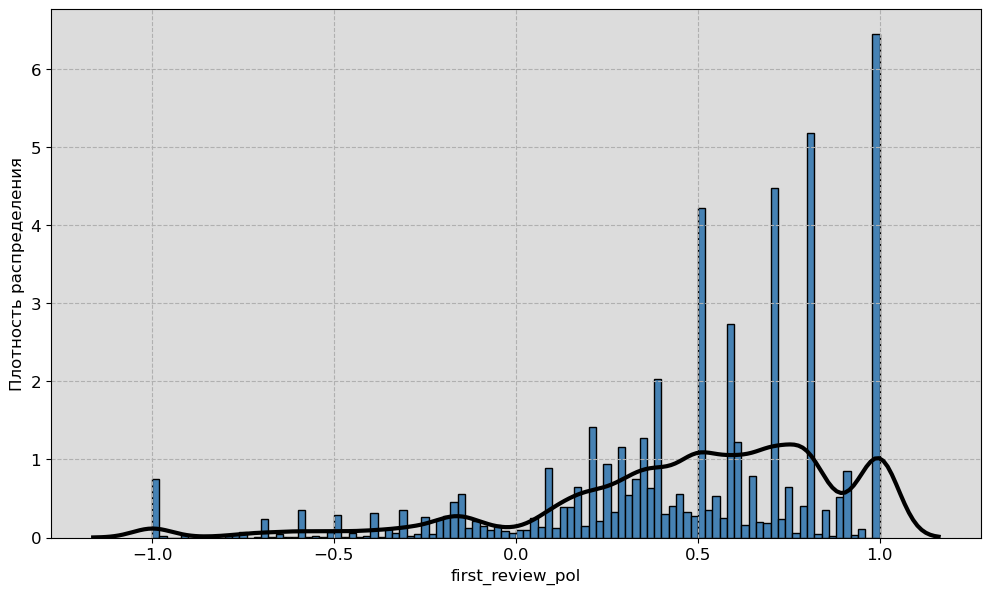

In [120]:
get_distplot(data[data['first_review_pol'] != 0], 'first_review_pol')

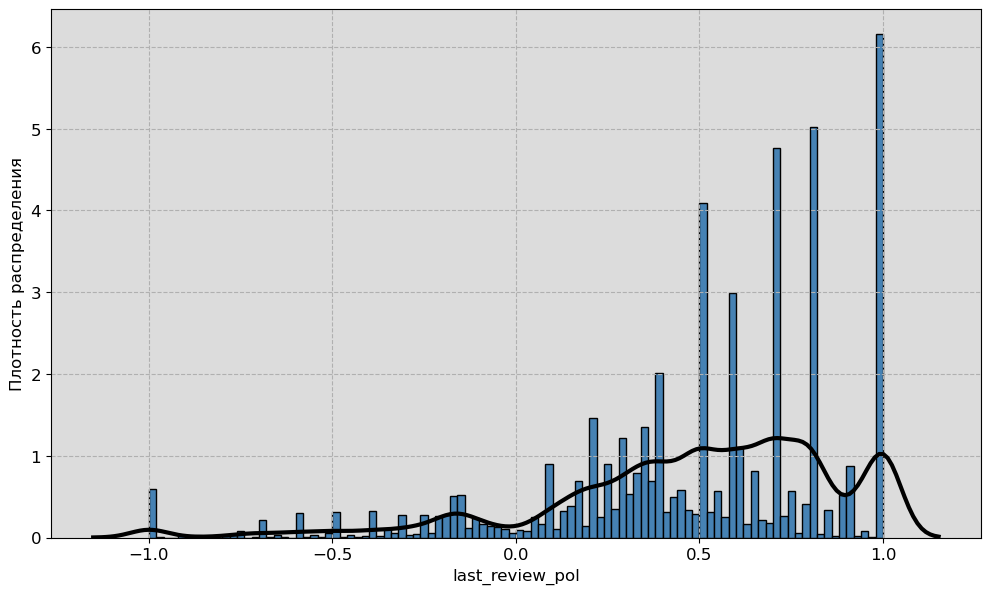

In [121]:
get_distplot(data[data['last_review_pol'] != 0], 'last_review_pol')

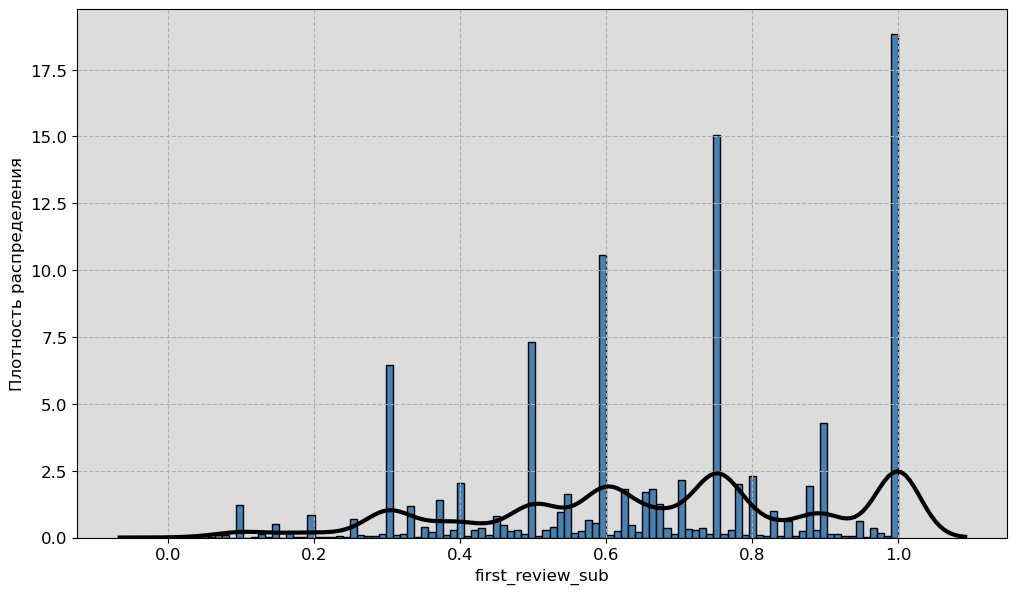

In [122]:
get_distplot(data[data['first_review_sub'] != 0], 'first_review_sub')

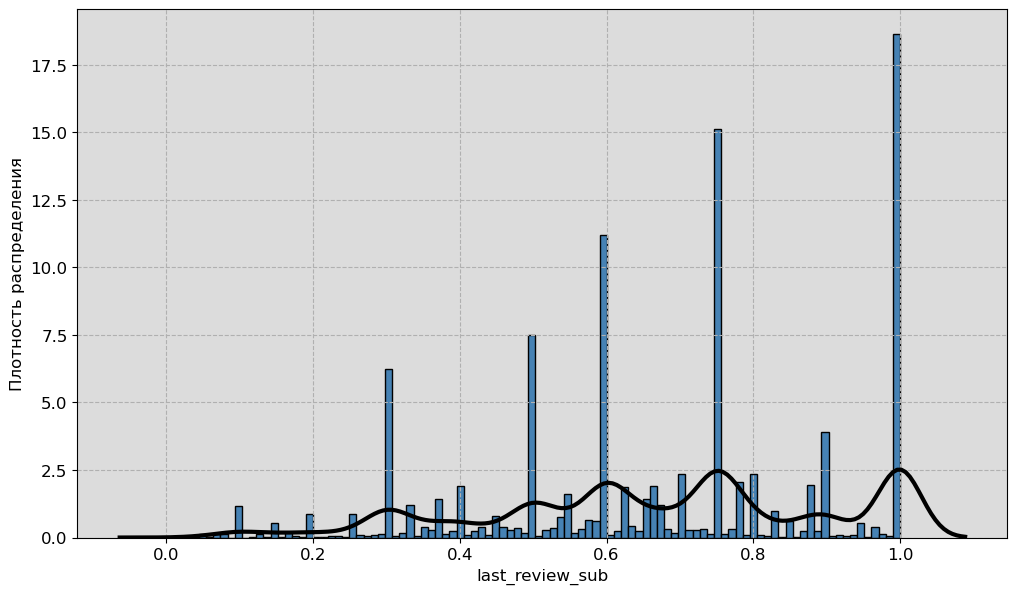

In [123]:
get_distplot(data[data['last_review_sub'] != 0], 'last_review_sub')

Анализ показывает, что большинсто отзывов положительны и субъективны.

[К содержанию](#0)

---

<a id="3.7"></a>
# [3.7 Number of Reviews](#3.7)

Процент пропусков в столбце number_of_reviews: 6.4


count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: number_of_reviews, dtype: float64

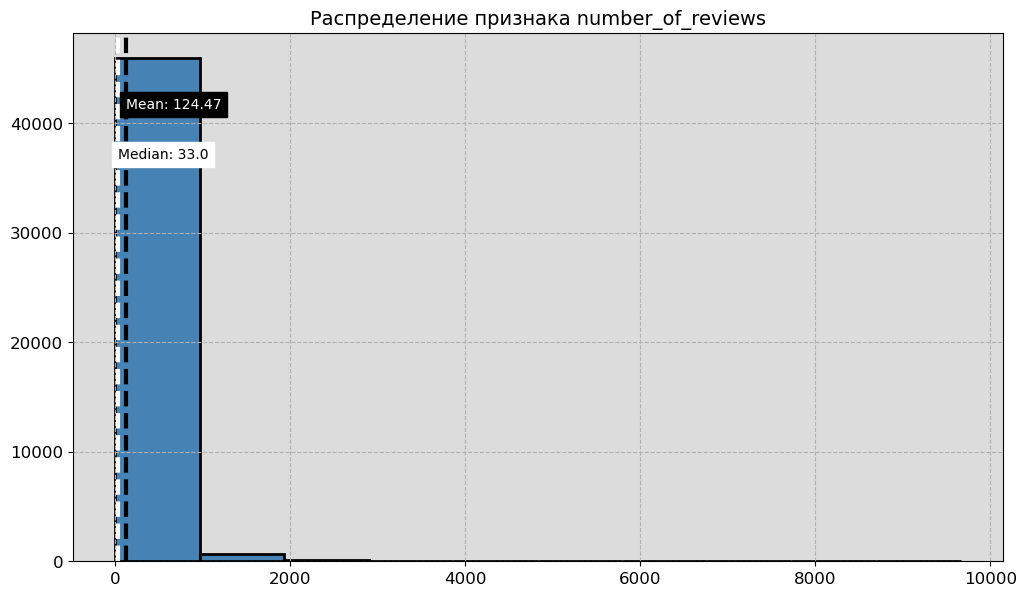

In [124]:
first_look(data, 'number_of_reviews')

В перменной присутствую пропуски, а распределение сильно смещенно влево. Сохраним информацию о пропусках:

In [125]:
nan_column(data, 'number_of_reviews')

Сами пропуски нужно как-то заполнить. Лучшим способом был бы парсинг по ссылкам из перменной __URL_TA__, чтобы достать актуальную информацию, но, при отсутствии соответсвующего скилла, воспользуемся информацие из датасета. Заполним пропуски данными о количестве отзывов в датасете:

In [126]:
data['number_of_reviews'] = data[['number_of_reviews', 'len_last_reviews']].\
                                apply(lambda x: x[1] if pd.isna(x[0]) else x[0], axis=1)

Создадим новый признак - сумма отзывов по городам:

In [127]:
rewiews_city_dict = dict(data.groupby('city')['number_of_reviews'].sum())

In [128]:
data['rewiews_city_number'] = data['city'].map(rewiews_city_dict)

In [129]:
data['rewiews_city_number'].describe()

count     50000.000000
mean     389940.169940
std      312559.088981
min       16701.000000
25%      106728.000000
50%      357202.000000
75%      680895.000000
max      934144.000000
Name: rewiews_city_number, dtype: float64

Логично предположить, что количество отзывов зависит от размера населения. Давайте проверим это предположение:

----------------
Корреляция: 0.86
----------------


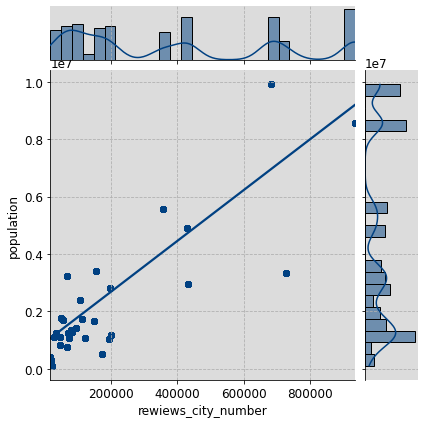

In [130]:
get_jointplot(data, 'rewiews_city_number', 'population')

Действительно, корреляция достаточно сильна. Создадим новый признак на основе этой корреляции:

In [131]:
data['reviews_city_number_to_population'] = data['rewiews_city_number']/data['population']*1000

In [132]:
data['reviews_city_number_to_population'].describe()

count    50000.000000
mean        93.981855
std         57.632800
min         20.907773
25%         64.164182
50%         68.749495
75%        109.039804
max        340.856612
Name: reviews_city_number_to_population, dtype: float64

[К содержанию](#0)

---

<a id="3.8"></a>
# [3.8 URL_TA и ID_TA](#3.8)

Посмотрим на последние 2 признака вместе. Так как на данный момент не представляется возможным использовать данные со страниц ресторанов, просто удалим переменную __URL_TA__ в дальнейшем. Посмотрим на __ID_TA__:

In [133]:
pct_missing(data, 'id_ta')

'Процент пропусков в столбце id_ta: 0.0'

In [134]:
data['id_ta'].describe()

count        50000
unique       49963
top       d3685055
freq             2
Name: id_ta, dtype: object

В перменной есть дубликаты, которых там быть не должно судя по информации к датасету. На данный момент не представляется возможным исправить это. Переведем значения в числа для дальнейшего применения в модели:

In [135]:
data['id_ta'] = data['id_ta'].apply(lambda x: int(x[1:]))

[К содержанию](#0)

---

<a id="4"></a>
# [4. Data Preprocessing](#4)

Удалим признаки, мешающие работе модели:

In [272]:
data_final = data.select_dtypes(exclude=['O', '<M8[ns]']).drop(['Lisbon', 'Amsterdam', 'Geneva', 'Rome', 'number_of_reviews_nan', 'last_review_sub', 'London', 'code_cuisine_style', 'rewiews_city_number', 'first_review_nan'], axis=1)

In [283]:
quest = ['Lisbon', 'Amsterdam', 'Geneva', 'Rome', 'number_of_reviews_nan', 'London', 'first_review_nan']
drop = ['last_review_sub', 'code_cuisine_style', 'rewiews_city_number']

Нормализуем часть признаков для улучшения работы модели:

In [274]:
for col in data_final.columns:
    if data_final[col].mean() > 5:
        data_final[col] = mm_scaler(data_final, col)

Посмотрим на финальный датасет:

In [244]:
data_final.sample(2)

,restaurant_id,ranking,price_range,number_of_reviews,id_ta,sample,rating,chained,capital,population,rest_counts,rest_counts_to_population,rank_2020,cost_of_living_index,rent_index,groceries_index,local_purchasing_power_index,mcmeal($),code_country,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Hamburg,Helsinki,Krakow,Ljubljana,Luxembourg,Lyon,Madrid,Milan,Munich,Oslo,Paris,Porto,Prague,Stockholm,Vienna,Warsaw,Zurich,cuisine_style_nan,cuisine_counts,rare_cuisine,rank_to_rest_counts,rank_to_population,price_range_nan,len_last_reviews,days_from_first_to_last,days_from_last_to_now,first_review_nan,last_review_nan,first_review_pol,first_review_sub,last_review_pol,rewiews_city_number,reviews_city_number_to_population
33197,0.275241,0.274889,2.0,0.001035,0.920499,1,4.0,1.0,0,0.491259,0.455171,0.690041,0.519481,0.183347,0.226747,0.150409,0.364201,0.580729,0.857143,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,1.331664,0.918902,0,1,0.000000,0.222733,1,0,0.0,0.0,0.6,0.449934,0.207492
19687,0.026672,0.026637,2.0,0.003830,0.381821,1,4.0,1.0,1,0.102865,0.036293,0.426009,0.233766,0.385597,0.323924,0.306655,0.718008,0.619792,0.190476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,0.924211,0.393722,0,2,0.006675,0.295815,0,0,0.6,0.9,0.2,0.013987,0.017438


In [245]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 61 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   restaurant_id                      50000 non-null  float64
 1   ranking                            50000 non-null  float64
 2   price_range                        50000 non-null  float64
 3   number_of_reviews                  50000 non-null  float64
 4   id_ta                              50000 non-null  float64
 5   sample                             50000 non-null  int64  
 6   rating                             50000 non-null  float64
 7   chained                            50000 non-null  float64
 8   capital                            50000 non-null  int64  
 9   population                         50000 non-null  float64
 10  rest_counts                        50000 non-null  float64
 11  rest_counts_to_population          50000 non-null  flo

Проверим, нет ли избыточной корреляции:

In [246]:
corr = data_final.drop(['sample'], axis=1).corr().abs()
corr = corr.unstack()
corr = corr.sort_values(ascending=False,kind="quicksort")
corr[(corr.values != 1)&(corr.values > 0.8)]

groceries_index        cost_of_living_index     0.965930
cost_of_living_index   groceries_index          0.965930
population             rest_counts              0.962449
rest_counts            population               0.962449
first_review_nan       len_last_reviews         0.939631
len_last_reviews       first_review_nan         0.939631
rest_counts            rewiews_city_number      0.927114
rewiews_city_number    rest_counts              0.927114
len_last_reviews       last_review_nan          0.909904
last_review_nan        len_last_reviews         0.909904
rank_2020              cost_of_living_index     0.891926
cost_of_living_index   rank_2020                0.891926
last_review_nan        days_from_last_to_now    0.864972
days_from_last_to_now  last_review_nan          0.864972
rewiews_city_number    population               0.859886
population             rewiews_city_number      0.859886
rank_2020              groceries_index          0.829787
groceries_index        rank_202

Есть высокая корреляция между признаками, но не критичная. Высокой корреляции признаков с целевой перменной не наблюдается

In [271]:
# def classic_round(d_num):
#     return int(d_num + (0.5 if d_num > 0 else -0.5))

# def my_round(d_pred):
#     result = classic_round(d_pred*2)/2
#     if result <=5:
#         return result
#     else:
#         return 5
    
# my_vec_round = np.vectorize(my_round)


# list_ofAllColumnsSortImportant = list(feat_importances.nlargest(len(train_data.columns)-1).index)
# min_MAE = round(MAE,3)
# print(f"min_MAE = {min_MAE}")
# remove_list = []
# log = []
# delta =0.002
# for i in range(0,len(list_ofAllColumnsSortImportant),1):
#     col = list_ofAllColumnsSortImportant[i]
#     print(f"{i}.{col}")
#     ###
#     train_data = data_final.query('sample == 1').drop(['sample'], axis=1)
#     test_data = data_final.query('sample == 0').drop(['sample'], axis=1)

#     y = train_data.rating.values            # наш таргет
#     X = train_data.drop(['rating']+[col], axis=1)

#     # Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
#     # выделим 20% данных на валидацию (параметр test_size)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
#     print(test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape)

#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_test)

#     y_pred = my_vec_round(y_pred)
#     temp_MAE = metrics.mean_absolute_error(y_test, y_pred)
#     ###
#     print(temp_MAE)
#     log.append([col, temp_MAE])
#     if round(temp_MAE,3) <= min_MAE-delta:
#         remove_list.append(col)
#         print(f"удаляем:= {col}")
#     else:
#         print(f"не удаляем:= {col}")
# print(f"i={i}")
# print(f"remove_list: {remove_list}")
# print(f"log_list: {log}")

# min_log = min_MAE
# for i in log:
#     if i[1] < min_log:
#         min_log = i[1]
#         x = i[0]
# print (f'Признак для удаления - {x}')

min_MAE = 0.195
0.rank_to_rest_counts
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


0.1649375
удаляем:= rank_to_rest_counts
1.number_of_reviews
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.228375
не удаляем:= number_of_reviews
2.reviews_city_number_to_population
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.166125
удаляем:= reviews_city_number_to_population
3.id_ta
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.164625
удаляем:= id_ta
4.rank_to_population
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.16025
удаляем:= rank_to_population
5.ranking
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.16025
удаляем:= ranking
6.restaurant_id
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.159625
удаляем:= restaurant_id
7.days_from_last_to_now
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.16425
удаляем:= days_from_last_to_now
8.last_review_pol
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1625625
удаляем:= last_review_pol
9.days_from_first_to_last
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.162875
удаляем:= days_from_first_to_last
10.cuisine_counts
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.16125
удаляем:= cuisine_counts
11.first_review_pol
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.162625
удаляем:= first_review_pol
12.population
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1608125
удаляем:= population
13.rent_index
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1603125
удаляем:= rent_index
14.Madrid
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.161
удаляем:= Madrid
15.first_review_sub
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1604375
удаляем:= first_review_sub
16.local_purchasing_power_index
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1609375
удаляем:= local_purchasing_power_index
17.code_country
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.160625
удаляем:= code_country
18.price_range
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1604375
удаляем:= price_range
19.rest_counts_to_population
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.161125
удаляем:= rest_counts_to_population
20.price_range_nan
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.161375
удаляем:= price_range_nan
21.rest_counts
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1601875
удаляем:= rest_counts
22.rank_2020
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


0.1595
удаляем:= rank_2020
23.groceries_index
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.160625
удаляем:= groceries_index
24.cost_of_living_index
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1598125
удаляем:= cost_of_living_index
25.cuisine_style_nan
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.160625
удаляем:= cuisine_style_nan
26.mcmeal($)
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.16075
удаляем:= mcmeal($)
27.len_last_reviews
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1603125
удаляем:= len_last_reviews
28.Hamburg
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1604375
удаляем:= Hamburg
29.capital
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1594375
удаляем:= capital
30.Porto
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.16025
удаляем:= Porto
31.first_review_nan
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.15875
удаляем:= first_review_nan
32.Berlin
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1595
удаляем:= Berlin
33.Barcelona
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1606875
удаляем:= Barcelona
34.last_review_nan
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1601875
удаляем:= last_review_nan
35.Stockholm
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.160375
удаляем:= Stockholm
36.Brussels
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.161125
удаляем:= Brussels
37.Munich
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1596875
удаляем:= Munich
38.Zurich
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.160875
удаляем:= Zurich
39.Milan
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1604375
удаляем:= Milan
40.Dublin
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.160875
удаляем:= Dublin
41.Edinburgh
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.16025
удаляем:= Edinburgh
42.chained
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


0.159375
удаляем:= chained
43.Lyon
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.159875
удаляем:= Lyon
44.Bratislava
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1594375
удаляем:= Bratislava
45.Krakow
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1603125
удаляем:= Krakow
46.Budapest
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1603125
удаляем:= Budapest
47.Prague
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


0.1595
удаляем:= Prague
48.Copenhagen
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.16025
удаляем:= Copenhagen
49.Vienna
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.160125
удаляем:= Vienna
50.rare_cuisine
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1603125
удаляем:= rare_cuisine
51.Warsaw
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.159375
удаляем:= Warsaw
52.Oslo
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1598125
удаляем:= Oslo
53.Paris
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1605
удаляем:= Paris
54.Helsinki
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1595
удаляем:= Helsinki
55.Ljubljana
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1600625
удаляем:= Ljubljana
56.Athens
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0.1601875
удаляем:= Athens
57.Luxembourg
(10000, 59) (40000, 59) (40000, 57) (32000, 57) (8000, 57)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s


0.160375
удаляем:= Luxembourg
i=57
remove_list: ['rank_to_rest_counts', 'reviews_city_number_to_population', 'id_ta', 'rank_to_population', 'ranking', 'restaurant_id', 'days_from_last_to_now', 'last_review_pol', 'days_from_first_to_last', 'cuisine_counts', 'first_review_pol', 'population', 'rent_index', 'Madrid', 'first_review_sub', 'local_purchasing_power_index', 'code_country', 'price_range', 'rest_counts_to_population', 'price_range_nan', 'rest_counts', 'rank_2020', 'groceries_index', 'cost_of_living_index', 'cuisine_style_nan', 'mcmeal($)', 'len_last_reviews', 'Hamburg', 'capital', 'Porto', 'first_review_nan', 'Berlin', 'Barcelona', 'last_review_nan', 'Stockholm', 'Brussels', 'Munich', 'Zurich', 'Milan', 'Dublin', 'Edinburgh', 'chained', 'Lyon', 'Bratislava', 'Krakow', 'Budapest', 'Prague', 'Copenhagen', 'Vienna', 'rare_cuisine', 'Warsaw', 'Oslo', 'Paris', 'Helsinki', 'Ljubljana', 'Athens', 'Luxembourg']
log_list: [['rank_to_rest_counts', 0.1649375], ['number_of_reviews', 0.228375]

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [275]:
# Теперь выделим тестовую часть
train_data = data_final.query('sample == 1').drop(['sample'], axis=1)
test_data = data_final.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [276]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [277]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 58), (40000, 58), (40000, 57), (32000, 57), (8000, 57))

[К содержанию](#0)

---

<a id="5"></a>
# [5. Model](#5)

Сам ML

In [278]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [279]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [280]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [281]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
MAE = metrics.mean_absolute_error(y_test, y_pred)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19557375


<AxesSubplot:>

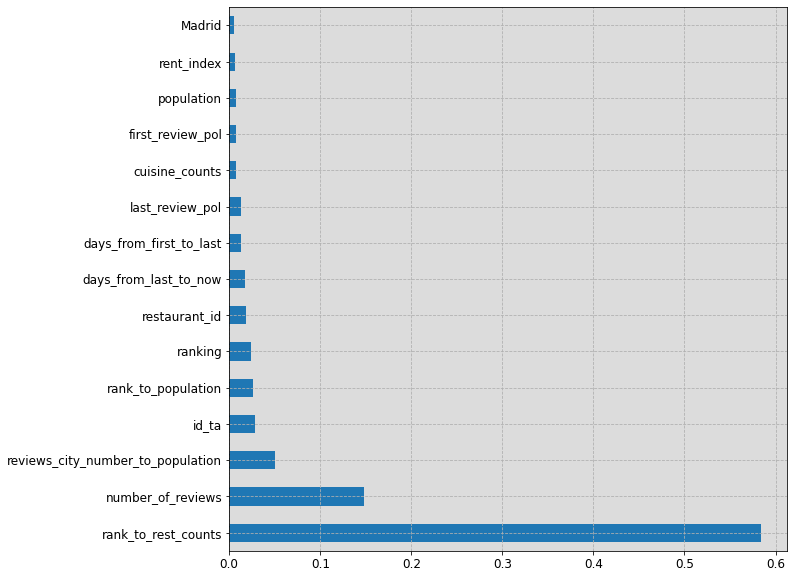

In [282]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

[К содержанию](#0)

---

<a id="6"></a>
# [6. Submission](#6)

Если все устраевает - готовим Submission на кагл

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['rating'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
for i in range(predict_submission.size):
        predict_submission[i]=round_prediction(predict_submission[i])

In [ ]:
predict_submission

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

[К содержанию](#0)